In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

## Load DataFrame with Pathing

In [3]:
df = pd.read_csv('data/POC_imagedata.csv')

In [4]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [5]:
#df = df.sample(750)

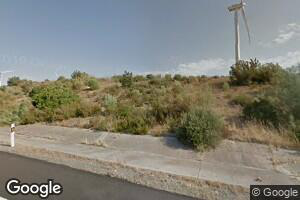

In [6]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [7]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [8]:
train.shape

(2400, 5)

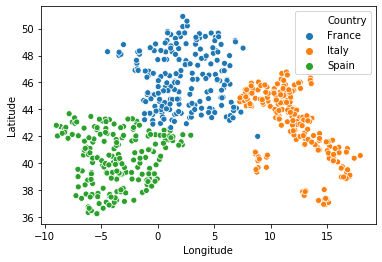

In [9]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [10]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [11]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    return x

In [12]:
def stitch_panos(path):
    return np.concatenate([img_to_np(path + direction + '.jpg') for direction in 'NESW'], axis=1)

In [13]:
def get_xy(path, y_map):
    x = stitch_panos(path)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [14]:
x, y = get_xy(train.Path.iloc[0], MAPPING)

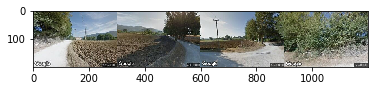

In [15]:
plt.imshow(x)

In [16]:
x.shape, y

((200, 1200, 3), 2)

#### Data Augmentation Functions

In [17]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, rand_r, rand_c, nr=200, nc=800):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, nr, nc)

def center_crop(x, nr=200, nc=800):
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    return crop(x, r_pix, c_pix, nr, nc)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [18]:
def apply_transforms(x, rand_arr, nr=200, nc=800):
    """ Applies a random crop, rotation"""
    rdeg = (rand_arr[0] -.50)*20
    x = rotate_cv(x, rdeg)
    if rand_arr[1] > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x, rand_arr[2], rand_arr[3], nr, nc)
    return x

In [19]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [20]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        self.random_init()
        
    def random_init(self):
        self.random = np.random.rand(len(self.paths), 4)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING)
        
        if self.transform:
            x = apply_transforms(x, self.random[idx])
        else:
            x = center_crop(x)
        
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y

In [21]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)

In [22]:
x, y = train_ds[1]
x.shape, y

((3, 200, 800), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


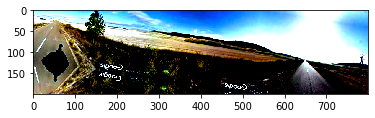

In [23]:
plt.imshow(np.moveaxis(x, 0, 2))

## Model

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 3))
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(self.dropout(x))
        return x

In [25]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [26]:
def train_epochs(model, optimizer, train_dl, valid_dl, epochs=10):
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y, reduction='sum')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
#         if val_acc > prev_val_acc: 
#             prev_val_acc = val_acc
#             if val_acc > 0.8:
#                 path = "data/models/model_resnet34_loss_{0:.0f}.pth".format(100*val_acc)
#                 save_model(model, path)
#                 print(path)
#     return sum_loss/total

In [27]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [28]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [29]:
def update_optimizer(optimizer, group_lrs, freeze):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]
        for p in param_group['params']:
            p.requires_grad = freeze[i]

In [30]:
model = Net().cuda()

In [31]:
params = [{'params': model.features1.parameters()},
              {'params': model.features2.parameters()},
              {'params': model.classifier.parameters()}]

In [32]:
optimizer = torch.optim.Adam(params, weight_decay=1e-5)

In [33]:
val_metrics(model, valid_dl)

(1.1115672079722088, 0.34833333333333333)

In [34]:
lr = 0.001
update_optimizer(optimizer, [0, 0, lr], [False, False, True])

In [35]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=5)

train_loss 1.056 val_loss 0.947 val_acc 0.560
train_loss 0.987 val_loss 0.892 val_acc 0.577
train_loss 0.963 val_loss 0.878 val_acc 0.597
train_loss 0.954 val_loss 0.865 val_acc 0.592
train_loss 0.971 val_loss 0.868 val_acc 0.590


In [36]:
update_optimizer(optimizer, [0, lr/50, lr], [False, True, True])

In [37]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=7)

train_loss 0.906 val_loss 0.805 val_acc 0.622
train_loss 0.785 val_loss 0.763 val_acc 0.642
train_loss 0.696 val_loss 0.729 val_acc 0.678
train_loss 0.576 val_loss 0.709 val_acc 0.698
train_loss 0.459 val_loss 0.722 val_acc 0.690
train_loss 0.326 val_loss 0.807 val_acc 0.702
train_loss 0.188 val_loss 0.953 val_acc 0.707


In [38]:
lr = 0.0001
update_optimizer(optimizer, [0, lr/50, lr], [False, True, True])

In [39]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.133 val_loss 0.928 val_acc 0.718
train_loss 0.115 val_loss 0.914 val_acc 0.718
train_loss 0.098 val_loss 0.943 val_acc 0.720
train_loss 0.105 val_loss 0.928 val_acc 0.705
train_loss 0.096 val_loss 0.930 val_acc 0.705
train_loss 0.084 val_loss 0.957 val_acc 0.697
train_loss 0.082 val_loss 0.966 val_acc 0.713
train_loss 0.085 val_loss 0.989 val_acc 0.695
train_loss 0.058 val_loss 0.969 val_acc 0.702
train_loss 0.064 val_loss 1.021 val_acc 0.703


## Prediction Evaluation

In [40]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path
1995,France,43.755137,0.367536,jNJY4pAtiAGKttaZizKNvg,data/images/France/0995/
1445,France,44.605571,0.143110,jOzCy1XwfNdGEfY2_-BIcw,data/images/France/0445/
2881,Italy,44.898228,7.391663,N6DDZGcmqydFiUGSR7SGHw,data/images/Italy/0881/
1533,France,45.590838,5.827836,F5jBUTp_nnHU_kuwULmyKw,data/images/France/0533/
836,Spain,41.653791,-2.297492,irceMsx9bKca7HFu1p1ujA,data/images/Spain/0836/


In [41]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

{0: 'Spain', 1: 'France', 2: 'Italy'}

In [42]:
preds = []
with torch.no_grad():
    model.eval()
    for x, y in valid_dl:
        out = model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [43]:
val['predictions'] = preds

In [44]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path,predictions
1995,France,43.755137,0.367536,jNJY4pAtiAGKttaZizKNvg,data/images/France/0995/,France
1445,France,44.605571,0.143110,jOzCy1XwfNdGEfY2_-BIcw,data/images/France/0445/,Italy
2881,Italy,44.898228,7.391663,N6DDZGcmqydFiUGSR7SGHw,data/images/Italy/0881/,France
1533,France,45.590838,5.827836,F5jBUTp_nnHU_kuwULmyKw,data/images/France/0533/,France
836,Spain,41.653791,-2.297492,irceMsx9bKca7HFu1p1ujA,data/images/Spain/0836/,Spain


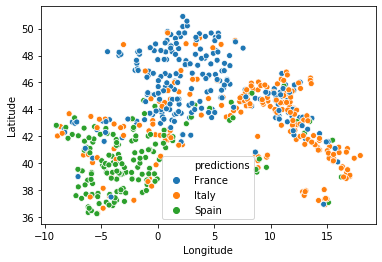

In [45]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='predictions')

In [46]:
(val.Country == val.predictions).sum() / len(val)

0.7033333333333334